In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import torch
import generator
import plotly.graph_objects as go
from itertools import combinations
from scipy.spatial.transform import Rotation as R
from sklearn.decomposition import PCA

In [2]:
def V(X, i, j):
    r_ij = X[i] - X[j]
    r = torch.norm(r_ij).pow(-6)
    return r.pow(2) - 2 * r

def center(X):
    Y = X - X[0]
    return Y
    
def system_potential(X):
    N, _ = X.shape
    energy = 0.0
    Y = center(X)
    for i in range(N - 1):
        for j in range(i + 1, N): 
            energy += V(Y, i, j)
    return energy

def line_search(X, energy, g, alpha_0=1.0, factor=0.5, c=1e-4, max_iter=10, tol=1e-8):
    alpha = alpha_0
    dot = torch.sum(-g * g).item()    
    for _ in range(max_iter):
        X_k = X - alpha * g
        energy_new = system_potential(X_k)

        if energy_new <= energy + c * alpha * dot:
            break
        alpha *= factor
        if alpha < tol:
            break
    return alpha

def gd_solve(natoms, lr=0.008, energy_tol=1e-8, tol=1e-8, max_iter=2001, debug=True, debug_rate=400, save_initial=False, gen=generator.uniform_sphere, track_energy=False):
    X = gen(natoms).clone().requires_grad_().to('cuda' if torch.cuda.is_available() else 'cpu', torch.float64)
    if save_initial:
        orig = X.clone()
    if track_energy:
        nrg_list = []

    for _iter_ in range(max_iter):
        energy = system_potential(X)
        if track_energy:
            nrg_list.append(energy.detach())
        g = torch.autograd.grad(energy, X)[0] 
        
        g_norm = g.norm().item()
        if g_norm < tol:
            if debug:
                print(f"Converged on step {_iter_}, energy: {energy.item():.6f}, gradient norm = {g_norm:.3e}")
            break
        
        with torch.no_grad(): 
            X -= line_search(X, energy, g) * g 
            X.requires_grad_() 

        energy_new = system_potential(X)

        if abs(energy_new - energy) < energy_tol:
            if debug:
                print(f"Converged on step {_iter_}, energy: {energy_new.item():.6f}, gradient norm = {g_norm:.3e}")
            break

        if debug and _iter_ % debug_rate == 0:
            print(f"Step {_iter_}, energy: {energy.item():.6f}, gradient norm: {g_norm:.2e}")
    if save_initial:
        return orig.detach(), center(X.detach()), energy    
    if track_energy: 
        return torch.tensor(nrg_list), energy
    return center(X.detach()), energy

In [3]:
def plot_3d_points(points, energy):
    points_np = center(points).numpy()
    N,_ = points_np.shape
    x = points_np[:, 0]
    y = points_np[:, 1]
    z = points_np[:, 2]
    fig = go.Figure()
    for i, j in combinations(range(len(points_np)), 2):
        edge_len = np.linalg.norm(points_np[i] - points_np[j])
        V_ij = V(points, i, j)
        fig.add_trace(go.Scatter3d(
            x=[points_np[i, 0], points_np[j, 0]],
            y=[points_np[i, 1], points_np[j, 1]],
            z=[points_np[i, 2], points_np[j, 2]],
            mode='lines',
            line=dict(color='rgb(173, 216, 230, 0.4)', width=8),
            showlegend=False, 
            hovertext=f"Length: {edge_len:.2e}, Contributes {V_ij:.2e}J",
            hoverinfo="text",
        ))
    fig.add_trace(go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers',
        hovertext=[f"Point {i + 1}" for i in range(N)],
        marker=dict(size=8, color='red'),
        showlegend=False
    ))
    fig.update_layout(
        scene=dict(
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False, title=''),  # Remove grid, zero line, and ticks
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False, title=''),
            zaxis=dict(showgrid=False, zeroline=False, showticklabels=False, title=''),
        ),
        title=f"{N}-Atom Configuration: {energy:.4f}J",
        width=600,
        height=400,
        plot_bgcolor='rgba(0,0,0,0)',
        paper_bgcolor='rgba(0,0,0,0)',
    )
    fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False)
    fig.show()

In [ ]:
for atoms in range(2,15):
    config = gd_solve(atoms, debug=False)
    plot_3d_points(*config)

In [4]:
# Verify that line search works right

X = generator.uniform_sphere(3).clone().requires_grad_(True)
for i in range(20):
    E = system_potential(X)
    g = torch.autograd.grad(E, X)[0]
    p = -g.view(-1)                        
    a = line_search(X, E, g, alpha_0=0.1)   # try 0.1 or whatever lr
    with torch.no_grad():
        X = X + a * p.view_as(X)
        X = X - X[0]
    X.requires_grad_(True)
    print(f"Iter {i:2d}: E = {E.item():.6f}, ‖grad‖ = {g.norm().item():.2e}, a = {a:.3f}")


Iter  0: E = -0.221921, ‖grad‖ = 7.62e-01, a = 0.100
Iter  1: E = -0.289849, ‖grad‖ = 1.04e+00, a = 0.100
Iter  2: E = -0.424871, ‖grad‖ = 1.61e+00, a = 0.100
Iter  3: E = -0.803233, ‖grad‖ = 3.29e+00, a = 0.100
Iter  4: E = -1.279765, ‖grad‖ = 3.61e+01, a = 0.006
Iter  5: E = -1.635842, ‖grad‖ = 6.56e+00, a = 0.025
Iter  6: E = -2.858243, ‖grad‖ = 5.87e+00, a = 0.013
Iter  7: E = -2.863041, ‖grad‖ = 9.64e+00, a = 0.006
Iter  8: E = -2.927801, ‖grad‖ = 4.59e+00, a = 0.006
Iter  9: E = -2.999994, ‖grad‖ = 4.41e-02, a = 0.006
Iter 10: E = -3.000000, ‖grad‖ = 1.52e-02, a = 0.006
Iter 11: E = -3.000000, ‖grad‖ = 5.25e-03, a = 0.006
Iter 12: E = -3.000000, ‖grad‖ = 1.80e-03, a = 0.025
Iter 13: E = -3.000000, ‖grad‖ = 7.38e-03, a = 0.006
Iter 14: E = -3.000000, ‖grad‖ = 2.58e-03, a = 0.013
Iter 15: E = -3.000000, ‖grad‖ = 4.34e-03, a = 0.006
Iter 16: E = -3.000000, ‖grad‖ = 1.52e-03, a = 0.025
Iter 17: E = -3.000000, ‖grad‖ = 6.68e-03, a = 0.006
Iter 18: E = -3.000000, ‖grad‖ = 2.33e-03, a =

In [ ]:

def strong_wolfe_line_search(X, energy, g, p,
                             alpha0=1.0, c1=1e-4, c2=0.9,
                             max_iter=20):
    def phi(a):
        Xt = X + a * p
        return system_potential(Xt).item()
    def der_phi(a):
        Xt = X + a * p
        Xt = Xt.clone().detach().requires_grad_(True)
        Et = system_potential(Xt)
        grad_t = torch.autograd.grad(Et, Xt)[0]
        return (grad_t.view(-1) @ p.view(-1)).item()

    alpha_prev = 0.0
    phi0       = energy
    derphi0    = (g.view(-1) @ p.view(-1)).item()
    alpha = alpha0
    phi_prev = phi0

    for i in range(max_iter):
        phi_a = phi(alpha)
        if (phi_a > phi0 + c1 * alpha * derphi0) or (i > 0 and phi_a >= phi_prev):
            # need to zoom between alpha_prev and alpha
            return zoom(alpha_prev, alpha, phi, der_phi, phi0, derphi0, c1, c2)
        derphi_a = der_phi(alpha)
        if abs(derphi_a) <= -c2 * derphi0:
            return alpha
        if derphi_a >= 0:
            # curvature condition violated: derivative has changed sign
            return zoom(alpha, alpha_prev, phi, der_phi, phi0, derphi0, c1, c2)
        alpha_prev, phi_prev = alpha, phi_a
        alpha = alpha * 2.0  # increase alpha and keep searching

    return alpha  # fallback

def zoom(a_lo, a_hi, phi, der_phi, phi0, derphi0, c1, c2):
    for j in range(20):
        # interpolate midpoint
        a_j = 0.5 * (a_lo + a_hi)
        phi_aj = phi(a_j)
        if (phi_aj > phi0 + c1 * a_j * derphi0) or (phi_aj >= phi(a_lo)):
            a_hi = a_j
        else:
            derphi_aj = der_phi(a_j)
            if abs(derphi_aj) <= -c2 * derphi0:
                return a_j
            if derphi_aj * (a_hi - a_lo) >= 0:
                a_hi = a_lo
            a_lo = a_j
    return a_j

In [122]:
def bfgs_step(X, energy, g, H_inv, alpha=1.0, max_iter=10, tol=1e-8):
    N, _ = X.shape

    # flatten & slice out the free variables
    g_full = g.view(-1)
    g_free = g_full[3:]
    # print("||g_full|| =", g_full.norm().item())
    # print("||g_free|| =", g_free.norm().item())
    # print("H_inv diag:", torch.diag(H_inv)[:6])
    # print("H_inv.shape =", H_inv.shape)
    # print("g_free.shape =", g_free.shape)

    # descent dir in the free subspace
    s_free = - H_inv @ g_free

    p = torch.zeros_like(g_full, device=g_full.device)
    p[3:] = s_free
    p = p.view_as(X)

    # line search (still uses the full X and full g)
    alpha = strong_wolfe_line_search(X, energy, g, p)

    # take a step in the free variables
    x_full = X.clone().detach().view(-1)
    x_free = x_full[3:]

    # print("||s_free|| =", s_free.norm().item())
    # print("alpha =", alpha)
    # print("x_free (first 5) =", x_free[:5])
    x_free_new = x_free + alpha * s_free
    # print("x_free_new (first 5) =", x_free_new[:5])
    # print("s = x_free_new - x_free (first 5) =", (x_free_new - x_free)[:5])

    # reassemble X_new
    x_full[3:] = x_free_new
    X_new = x_full.view(N,3).requires_grad_(True)

    # eval new energy & gradient
    energy_new = system_potential(X_new)
    g_new_full = torch.autograd.grad(energy_new, X_new)[0]
    g_new = g_new_full.view(-1)
    g_new_free = g_new[3:]

    # BFGS inverse‐Hessian update on the free subspace
    w = alpha * s_free
    y = g_new_free - g_free
    # print (f"y={y}")
    # print (f"s={s}")
    # print (f"ys={y @ s}")
    ys = (y @ w).item()
    # print(f"||s|| = {w.norm().item():.2e}, ||y|| = {y.norm().item():.2e}, y^T s = {ys:.2e}")


    if ys <= 1e-24:
        H_inv_new = H_inv.clone()
        valid = True
    else:
        #print ("does this run")
        rho = 1.0 / ys
        I   = torch.eye(H_inv.shape[0], device=H_inv.device)
        V   = I - rho * torch.outer(w, y)
        with torch.no_grad():
            H_inv_new = V @ H_inv @ V.T + rho * torch.outer(w, w)
        valid = True

    return X_new, energy_new, g_new_full, H_inv_new, alpha, valid

def bfgs(natoms, lr=0.008, g_tol=1e-8, energy_tol=1e-8, max_iter=2001, debug=True, debug_rate=400, save_initial=False, gen=generator.uniform_sphere, track_energy=False):
    X = gen(natoms).clone().requires_grad_().to('cuda' if torch.cuda.is_available() else 'cpu', torch.float64)
    if save_initial:
        orig = X.clone()
    N, _ = X.shape
    H_inv = torch.eye(3 * (N - 1), dtype=torch.float64).to(X.device) 

    X = X.clone().detach().requires_grad_(True) # make sure autograd returns valid

    if track_energy: 
        nrg_list = [system_potential(X)]
    for _iter_ in range(max_iter):
        energy = system_potential(X)
        g = torch.autograd.grad(energy, X)[0]

        X_new, energy_new, g_new, H_inv, alpha, valid = bfgs_step(X, energy, g, H_inv, alpha=lr)

        if track_energy and valid: 
            nrg_list.append(energy_new.detach())
        
        if abs(energy_new - energy) < energy_tol:
            if debug:
                print(f"Converged on step {_iter_}, energy: {energy_new.item():.6f}, gradient norm = {g_norm:.3e}")
            break

        g_norm = g.norm().item()
        if g_norm < g_tol:
            if debug:
                print(f"Converged on step {_iter_}, energy: {energy.item():.6f}, gradient norm = {g_norm:.3e}")
            break
        
        if debug and _iter_ % debug_rate == 0:
            print(f"Step {_iter_}, energy: {energy_new.item():.6f}, gradient norm: {g_norm:.2e}, step size: {alpha:.4e}")
        
        X, energy = X_new, energy_new

    if save_initial:
        return orig.detach(), X.detach(), energy_new 
    if track_energy: 
        print (len(nrg_list))
        return torch.tensor(nrg_list), energy_new

    return X.detach(), energy_new

In [123]:
config = bfgs(15, debug=True, g_tol=1e-8, energy_tol=1e-12, debug_rate=20, track_energy=False)
plot_3d_points(*config)

Step 0, energy: -0.000013, gradient norm: 3.95e+02, step size: 5.0000e-01
Step 20, energy: -3.000000, gradient norm: 8.07e-02, step size: 1.0000e+00
Converged on step 24, energy: -3.000000, gradient norm = 8.425e-05


In [124]:
for atoms in range(2,10):
    config = bfgs(atoms, debug=False, g_tol=1e-8, energy_tol=1e-8, debug_rate=20)
    plot_3d_points(*config)

In [13]:
def plot_convergence_order(energies, final_energy, label=""):
    """
    energies: 1D tensor [E0, E1, ..., E_N]
    final_energy: scalar tensor E*
    
    Plots (log10 e_n, log10 e_{n+1}) with a linear fit whose slope ≈ order p.
    """
    # 1) drop last energy
    E = energies[:-1]
    # 2) absolute errors
    errs = (E - final_energy).abs()
    # 3) log10 errors, set zeros to -inf
    log_err = torch.where(errs > 0,
                          errs.log10(),
                          torch.full_like(errs, float("-inf")))
    # 4) keep only finite entries
    mask = torch.isfinite(log_err)
    log_err = log_err[mask]
    # 5) x = log_err[:-1], y = log_err[1:]
    x = log_err[:-1]
    y = log_err[1:]
    # 6) compute slope p and intercept a in torch
    xm = x.mean()
    ym = y.mean()
    num = ((x - xm) * (y - ym)).sum()
    den = ((x - xm)**2).sum()
    p = num / den              # slope
    a = ym - p * xm            # intercept
    
    # 7) convert to NumPy for plotting
    x_np = x.detach().numpy()
    y_np = y.detach().numpy()
    p_val = p.item()
    a_val = a.item()
    
    # 8) plot
    plt.figure()
    plt.plot(x_np, y_np, "o", label="data")
    plt.plot(x_np, p_val * x_np + a_val, "-", label=f"slope ≈ {p_val:.2f}")
    plt.xlabel("log10(error_n)")
    plt.ylabel("log10(error_{n+1})")
    plt.title(f"Estimated {label}Convergence Order p ≈ {p_val:.2f}")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.show()

def plot_convergence(energies, final_energy, label=""):
    """
    Plots the convergence of absolute errors on a log10 scale,
    ignoring the last entry in the energies tensor.
    
    energies: 1D torch.Tensor of computed energies [E0, E1, ..., EN]
    final_energy: scalar torch.Tensor (or float castable) E*
    """
    # drop the last computed energy
    E = energies[:-1]
    errors = (E - final_energy).abs()
    
    # compute log10(errors), putting -inf where error is zero
    log_errors = torch.where(
        errors > 0,
        errors.log10(),
        torch.full_like(errors, float("-inf"))
    )
    
    # move to CPU+NumPy for plotting
    iters = torch.arange(log_errors.size(0)).cpu().numpy()
    log_e = log_errors.detach().numpy()
    
    plt.figure()
    plt.plot(iters, log_e, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('log10(|Error|)')
    plt.title(f'{label}Convergence on Log Scale')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    plot_convergence_order(energies, final_energy, label)

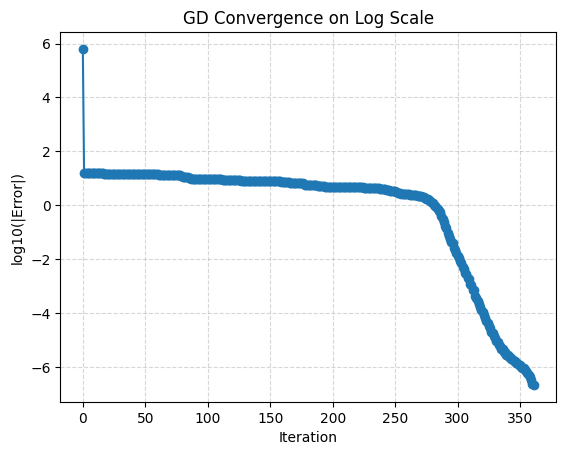

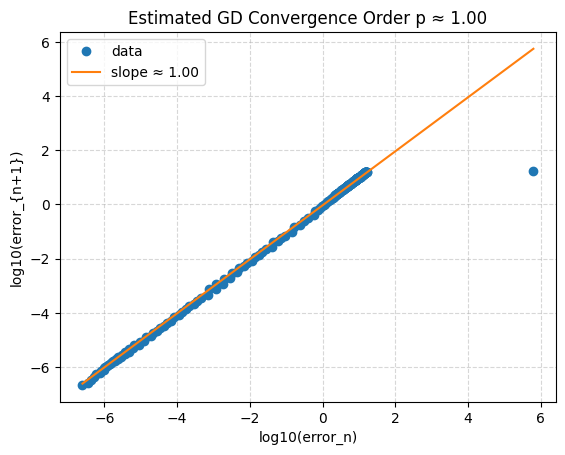

In [86]:
plot_convergence(*(gd_solve(15, track_energy=True, debug=False, gen=generator.init_pos)), label="GD ")

46


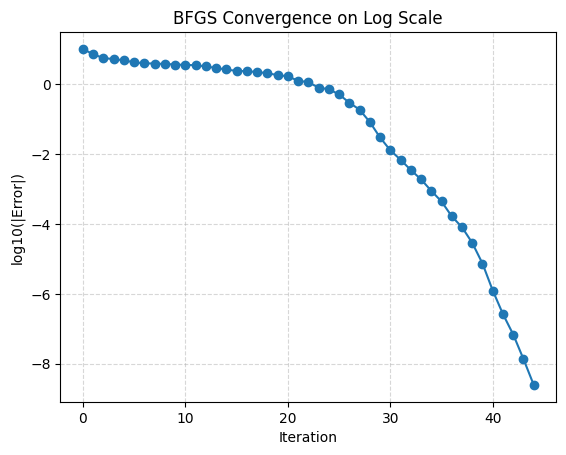

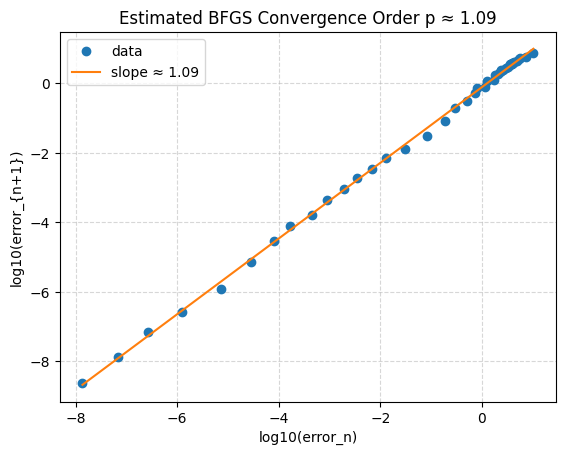

In [129]:
plot_convergence(*(bfgs(8, track_energy=True, debug=False, gen=generator.uniform_sphere)), label="BFGS ")